## CSS Project Part 2
Arathy Pillai, Alexander Guth, Hammad Akthar, Hiba Saleel and Julian Jetz

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.plotting import scatter_matrix
from string import punctuation
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import statsmodels.api as sm

In [2]:
plot_size = plt.rcParams["figure.figsize"]  
plot_size[0] = 15  
plot_size[1] = 8  
plt.rcParams["figure.figsize"] = plot_size  

### Load data and determine na values
repost and Text are determined as na values, because they ... **[TODO]**

In [3]:
na_values = ['nan', 'N/A', 'NaN', 'NaT', '0', '', 'Text', 'repost', 'r e p o s t -', 'Repost']
ira_data = pd.read_csv('../Data/data_IRA_Ads.csv', sep=";", parse_dates=['AD_CREATION_DATE', 'AD_END_DATE'], 
                       dayfirst=False, index_col='AD_ID', na_values=na_values)
#ira_data = ira_data[(ira_data['AD_IMPRESSIONS']> 0) & ira_data['AD_CLICKS'] > 0]

### Click per View Ratio
#Clicks / #Impressions

In [4]:
ira_data.insert(5, 'AD_CLICKS_PER_VIEW', ira_data['AD_CLICKS']/ira_data['AD_IMPRESSIONS'])

### Date operations
Get epoch time (ms since 01.01.1970)

In [5]:
epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0

def time_to_ms(dt):
    return dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1000 / 1000

In [6]:
ira_data['AD_CREATION_WEEKDAY'] = ira_data['AD_CREATION_DATE'].dt.dayofweek
ira_data['AD_CREATION_YEAR'] = ira_data['AD_CREATION_DATE'].dt.year
ira_data['AD_CREATION_MONTH'] = ira_data['AD_CREATION_DATE'].dt.month
ira_data['AD_CREATION_DAY'] = ira_data['AD_CREATION_DATE'].dt.day
ira_data['AD_CREATION_TIME'] = ira_data['AD_CREATION_DATE'].apply(lambda x: time_to_ms(x))
ira_data['AD_CREATION_EPOCH_TIME'] = ira_data['AD_CREATION_DATE'].apply(lambda x: unix_time_millis(x))

### Convert ruble
Removes "RUB" from the cell AD_SPEND

In [7]:
ira_data['AD_SPEND']=ira_data['AD_SPEND'].str.replace(' RUB','').astype('float')

### Drop all subsets, where AD_TEXT is na

In [8]:
ira_data=ira_data.dropna(subset=['AD_TEXT']);
ira_data['AD_TEXT'].count()

3436

### Cleaning up Targeting Data

In [9]:
def remove_punctuation_at_the_end(x):
    #remove "," and "." and ":" from the end of x
    x = x.rstrip(',')
    x = x.rstrip('.')
    x = x.rstrip(':')
    #replace ";" and ",." with "," in x
    x = x.replace(';', ',')
    x = x.replace(',.', ',')
    return x

In [10]:
#replace abbreviations with their long form in AD_TARGETING_EXCLUDED_CONNECTIONS
ira_data['AD_TARGETING_EXCLUDED_CONNECTIONS']=ira_data['AD_TARGETING_EXCLUDED_CONNECTIONS'].str.replace('Exclude people who like BM','Exclude people who like Black Matters')

#replace ")or" (missing space) with ") or" and ");" with ")," in AD_TARGETING_LANGUAGE due to having a different formats used
ira_data['AD_TARGETING_LANGUAGE'] = ira_data['AD_TARGETING_LANGUAGE'].str.replace('\)or', ') or')
ira_data['AD_TARGETING_LANGUAGE'] = ira_data['AD_TARGETING_LANGUAGE'].str.replace('\);', '),')

#??Remove lines without AD_TARGETING_INTERESTS and execute remove_punctuation_at_the_end on each string in AD_TARGETING_INTERESTS
ira_data['AD_TARGETING_INTERESTS'] = ira_data['AD_TARGETING_INTERESTS'].dropna().apply(lambda x: remove_punctuation_at_the_end(str(x)))
ira_data['AD_TARGETING_PEOPLE_WHO_MATCH'] = ira_data['AD_TARGETING_PEOPLE_WHO_MATCH'].dropna().apply(lambda x: remove_punctuation_at_the_end(str(x)))
ira_data['AD_TARGETING_EXCLUDE'] = ira_data['AD_TARGETING_EXCLUDE'].dropna().apply(lambda x: remove_punctuation_at_the_end(str(x)))

### Remove hyperlinks

In [11]:
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'https?:\/\/.*[\r\n]*', '')
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'http?:\/\/.*[\r\n]*', '')

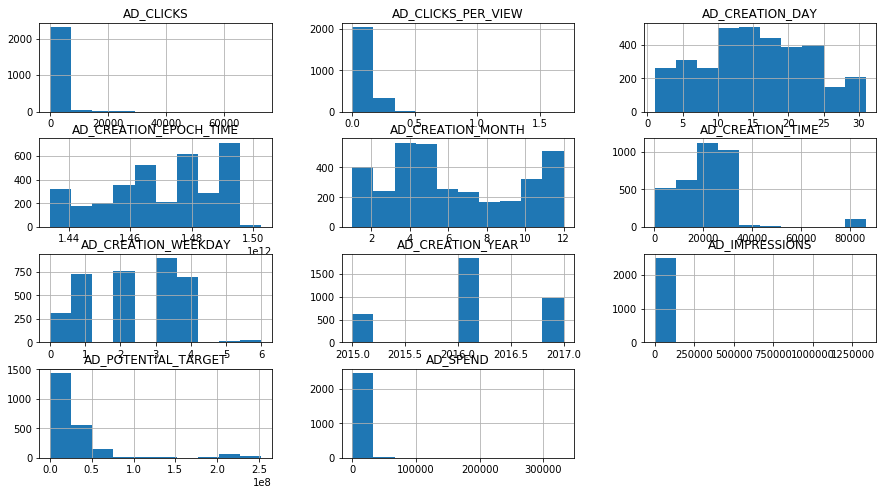

In [12]:
ira_data.hist();

### Flag all duplicate ad texts

In [13]:
ira_data['Duplicate'] = ira_data['AD_TEXT'].duplicated(keep=False)

### Total Duplicates

In [14]:
ira_data['AD_TEXT'].count()

3436

In [15]:
ira_data['Duplicate'].value_counts()

False    1998
True     1438
Name: Duplicate, dtype: int64

### Unique Duplicate Pairs

In [16]:
ira_data['AD_TEXT'][ira_data['Duplicate'] == True].nunique()

361

### Occurence of Duplicate Pairs

In [17]:
ira_data['AD_TEXT'][ira_data['Duplicate'] == True].value_counts().values

array([53, 23, 18, 16, 14, 14, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10,
       10, 10,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2

In [18]:
ira_data[(ira_data['Duplicate'] == True) & ira_data['AD_TEXT'].str.match('We speak for all fellow members of LGBT community across the nation.')][['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CREATION_DATE', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH','AD_CREATION_DAY','AD_CREATION_TIME','AD_TEXT', 'AD_SPEND', 'AD_POTENTIAL_TARGET']].head(20)

,AD_CLICKS,AD_IMPRESSIONS,AD_CREATION_DATE,AD_CREATION_WEEKDAY,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY,AD_CREATION_TIME,AD_TEXT,AD_SPEND,AD_POTENTIAL_TARGET
AD_ID,,,,,,,,,,,
580,103.0,122.0,2015-06-16 03:36:10,1,2015,6,16,12970.0,We speak for all fellow members of LGBT commun...,129.66,35000000.0
581,36.0,1438.0,2015-06-17 03:15:18,2,2015,6,17,11718.0,We speak for all fellow members of LGBT commun...,1362.57,144000000.0
582,1724.0,18891.0,2015-06-18 00:58:48,3,2015,6,18,3528.0,We speak for all fellow members of LGBT commun...,10085.77,35000000.0
583,186.0,4265.0,2015-06-22 08:19:07,0,2015,6,22,29947.0,We speak for all fellow members of LGBT commun...,1393.55,139000000.0
584,3206.0,31618.0,2015-06-23 05:06:57,1,2015,6,23,18417.0,We speak for all fellow members of LGBT commun...,16630.20,143000000.0
585,1252.0,11857.0,2015-07-01 02:55:07,2,2015,7,1,10507.0,We speak for all fellow members of LGBT commun...,5538.24,165000000.0
586,59.0,1811.0,2015-07-07 01:51:07,1,2015,7,7,6667.0,We speak for all fellow members of LGBT commun...,757.65,166000000.0
587,542.0,15175.0,2015-07-09 01:50:28,3,2015,7,9,6628.0,We speak for all fellow members of LGBT commun...,6201.70,35000000.0
588,21449.0,175460.0,2015-07-14 00:01:38,1,2015,7,14,98.0,We speak for all fellow members of LGBT commun...,93754.38,41000000.0


### Dealing with Missing Values

Multiple Imputation using MICE (Multiple Imputation by Chained Equations)

In [19]:
# https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-2-222154b4b58e
#from fancyimpute import MICE
#ira_cols=list(ira_data)
#ira_data = pd.DataFrame(MICE(verbose=False).complete(ira_data))
#ira_data.columns = ira_cols

### Common Statistics
**[TODO]** Mean, median etc. for success --> Chart(?) ==> Alex

### Correlations
**TODO** Handling of Outliers?, beautify the plot (axis labels, etc.), correlation of time

In [20]:
colormap = plt.cm.RdBu

In [21]:
corrDf = ira_data[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].dropna()

In [22]:
std_dev = 3
corrDf = corrDf[(np.abs(stats.zscore(corrDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY']])) < float(std_dev)).all(axis=1)]

In [23]:
corrDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1561 entries, 1 to 3517
Data columns (total 11 columns):
AD_CLICKS                 1561 non-null float64
AD_IMPRESSIONS            1561 non-null float64
AD_CLICKS_PER_VIEW        1561 non-null float64
AD_SPEND                  1561 non-null float64
AD_POTENTIAL_TARGET       1561 non-null float64
AD_CREATION_WEEKDAY       1561 non-null int64
AD_CREATION_EPOCH_TIME    1561 non-null float64
AD_CREATION_YEAR          1561 non-null int64
AD_CREATION_MONTH         1561 non-null int64
AD_CREATION_DAY           1561 non-null int64
AD_CREATION_TIME          1561 non-null float64
dtypes: float64(7), int64(4)
memory usage: 146.3 KB


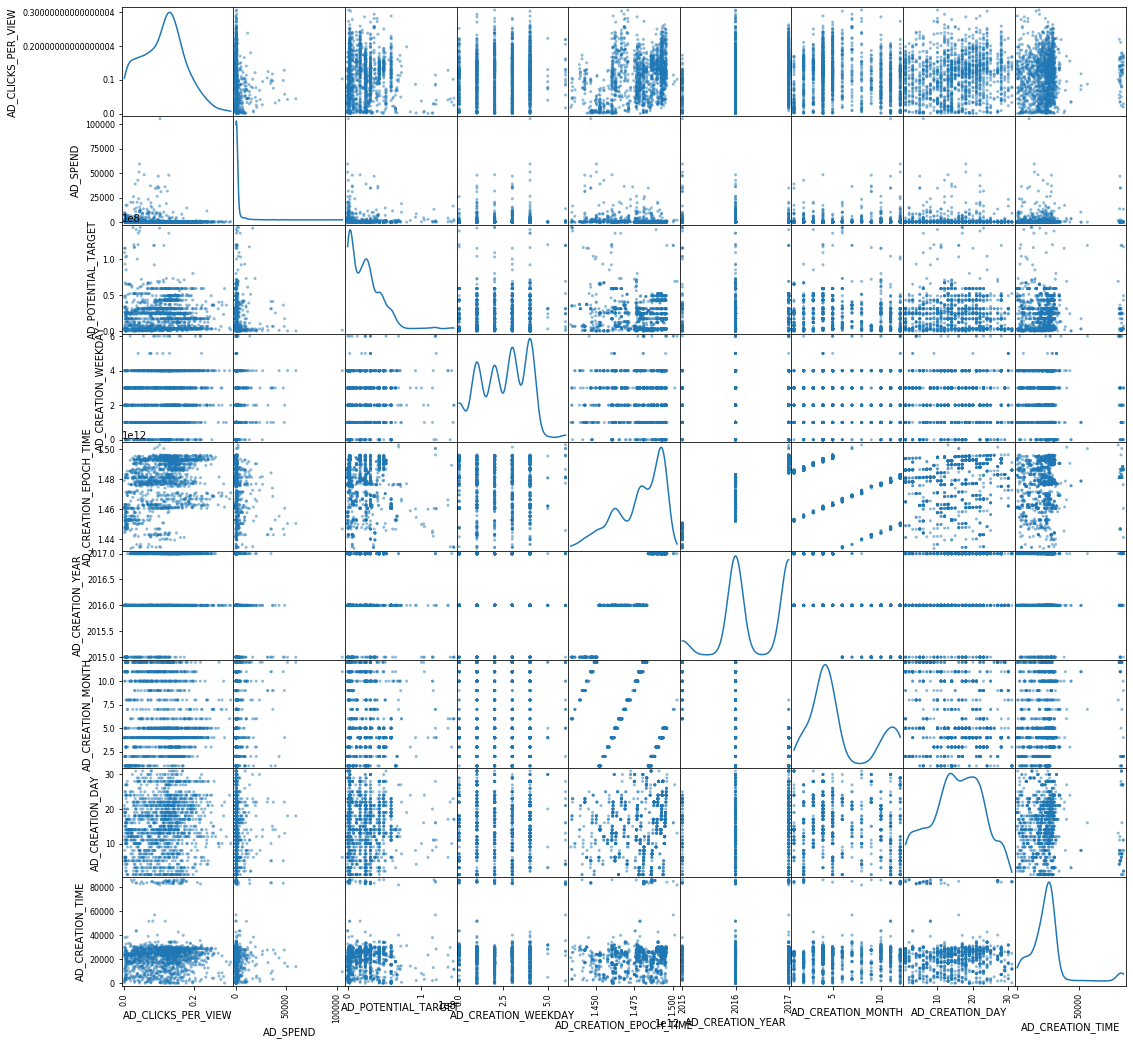

In [24]:
scatter_matrix(corrDf[['AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']], diagonal='kde', figsize=(18, 18))
plt.savefig(r"../Images/scatterALL.png")

In [25]:
corr = corrDf[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].corr()
corr

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_SPEND,AD_POTENTIAL_TARGET,AD_CREATION_EPOCH_TIME,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY,AD_CREATION_TIME
AD_CLICKS,1.000000,0.774459,0.276032,0.312826,0.082201,0.234158,0.215610,-0.062069,-0.003416,0.095631
AD_IMPRESSIONS,0.774459,1.000000,-0.065630,0.543079,0.041728,0.057677,0.052223,-0.011018,-0.035323,0.032362
AD_CLICKS_PER_VIEW,0.276032,-0.065630,1.000000,-0.152962,-0.010226,0.355368,0.323261,-0.096563,0.154860,0.080396
AD_SPEND,0.312826,0.543079,-0.152962,1.000000,-0.067132,-0.210235,-0.211786,0.097488,-0.043595,-0.010906
AD_POTENTIAL_TARGET,0.082201,0.041728,-0.010226,-0.067132,1.000000,-0.154291,-0.083515,-0.081568,-0.016343,-0.038136
AD_CREATION_EPOCH_TIME,0.234158,0.057677,0.355368,-0.210235,-0.154291,1.000000,0.890258,-0.214027,0.193047,0.132188
AD_CREATION_YEAR,0.215610,0.052223,0.323261,-0.211786,-0.083515,0.890258,1.000000,-0.634262,0.202631,0.048024
AD_CREATION_MONTH,-0.062069,-0.011018,-0.096563,0.097488,-0.081568,-0.214027,-0.634262,1.000000,-0.176425,0.122433
AD_CREATION_DAY,-0.003416,-0.035323,0.154860,-0.043595,-0.016343,0.193047,0.202631,-0.176425,1.000000,-0.033065
AD_CREATION_TIME,0.095631,0.032362,0.080396,-0.010906,-0.038136,0.132188,0.048024,0.122433,-0.033065,1.000000


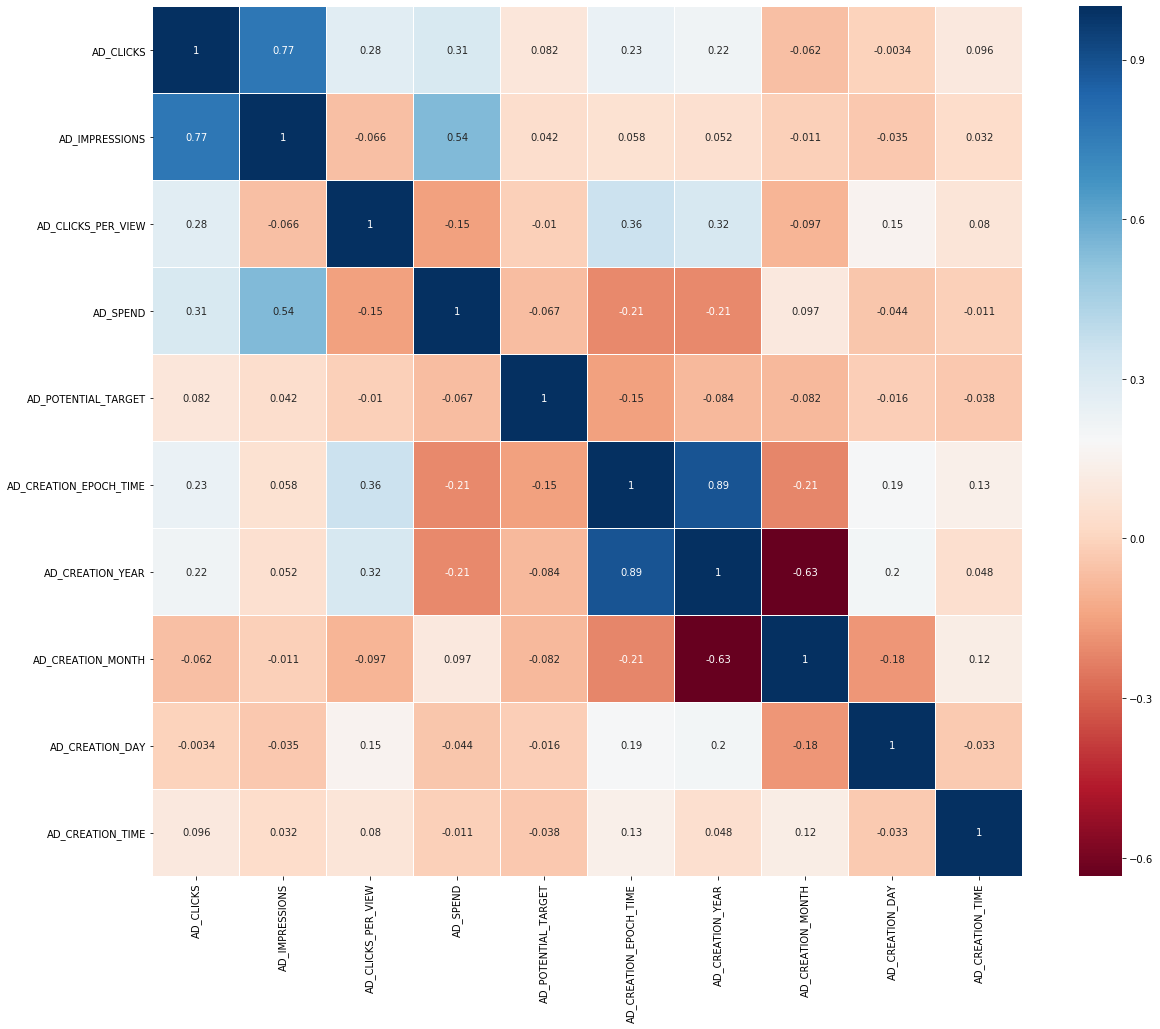

In [26]:
ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(corr,ax=ax,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);
plt.savefig(r"../Images/corrALL.png")

In [27]:
corrDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_CREATION_WEEKDAY']].corr(method='spearman')

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_CREATION_WEEKDAY
AD_CLICKS,1.000000,0.890972,0.491061,0.067645
AD_IMPRESSIONS,0.890972,1.000000,0.143829,0.046365
AD_CLICKS_PER_VIEW,0.491061,0.143829,1.000000,0.072965
AD_CREATION_WEEKDAY,0.067645,0.046365,0.072965,1.000000


#### Correlation: Unique Dataset

In [28]:
corrUniqueDf = ira_data[ira_data['Duplicate']==False][[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].dropna()

In [ ]:
scatter_matrix(corrUniqueDf[['AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']], diagonal='kde', figsize=(18, 18))
plt.savefig(r"../Images/scatterUnique.png")

In [ ]:
uCorr = corrUniqueDf[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].corr()
uCorr

In [ ]:
ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(uCorr, ax=ax,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);
plt.savefig(r"../Images/corrUnique.png")

In [ ]:
corrUniqueDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_CREATION_WEEKDAY']].corr(method='spearman')

#### Correlation: Duplicate Dataset

In [ ]:
corrDuplicateDf = ira_data[ira_data['Duplicate']==True][[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].dropna()

In [ ]:
scatter_matrix(corrDuplicateDf[['AD_CLICKS_PER_VIEW', 'AD_SPEND','AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']], diagonal='kde', figsize=(18, 18))
plt.savefig(r"../Images/scatterDuplicate.png")

In [ ]:
dCorr = corrDuplicateDf[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].corr()
dCorr

In [ ]:
ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(dCorr,ax=ax,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);
plt.savefig(r"../Images/corrDuplicate.png")

In [ ]:
corrDuplicateDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_CREATION_WEEKDAY']].corr(method='spearman')

### Regression Model
**[TODO]** ==> Julian

In [ ]:
X= corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME', 'AD_POTENTIAL_TARGET', 'AD_SPEND']]
#X= corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_DAY', 'AD_CREATION_MONTH', 'AD_CREATION_YEAR', 'AD_POTENTIAL_TARGET', 'AD_SPEND', 'AD_CREATION_TIME']]
Y= corrDf['AD_CLICKS_PER_VIEW']

In [ ]:
sc = StandardScaler()
X_std = sc.fit_transform(X)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=0)

#### Normal Multiple Linear Regression

In [ ]:
reg = LinearRegression()
reg.fit(X_train, Y_train)

In [ ]:
y_pred = reg.predict(X_test)

In [ ]:
print(reg.coef_)

In [ ]:
print(reg.intercept_)

In [ ]:
plt.scatter(reg.predict(X_train), reg.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(reg.predict(X_test), reg.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y=0, xmin=-0.05, xmax=0.2)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

**Very low R^2 score, so the prediction isn't very good**

In [ ]:
r2_score(Y_test, y_pred)

In [ ]:
reg.score(X_test,Y_test)

In [ ]:
mean_squared_error(Y_test, y_pred)

#### Multiple Linear Regression (Lasso)

In [ ]:
regLasso = Lasso()
regLasso.fit(X_train, Y_train)

In [ ]:
y_pred_lasso = regLasso.predict(X_test)

In [ ]:
print(regLasso.coef_)

In [ ]:
print(regLasso.intercept_)

In [ ]:
plt.scatter(regLasso.predict(X_train), regLasso.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(regLasso.predict(X_test), regLasso.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y=0, xmin=-0.075, xmax=0.2)
plt.title('Residual Plot using Lasso using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

**Also a very low R^2 score, so the prediction isn't very good**

In [ ]:
r2_score(Y_test, y_pred_lasso)

In [ ]:
regLasso.score(X_test,Y_test)

In [ ]:
mean_squared_error(Y_test, y_pred_lasso)

#### Multiple Linear Regression (Ridge)

In [ ]:
regRidge = Ridge()
regRidge.fit(X_train, Y_train)

In [ ]:
y_pred_ridge = regRidge.predict(X_test)

In [ ]:
print(regRidge.coef_)

In [ ]:
print(regRidge.intercept_)

In [ ]:
plt.scatter(regRidge.predict(X_train), regRidge.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(regRidge.predict(X_test), regRidge.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y=0, xmin=-0.075, xmax=0.25)
plt.title('Residual Plot using Ridge using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

In [ ]:
r2_score(Y_test, y_pred_ridge)

In [ ]:
regRidge.score(X_test, Y_test)

In [ ]:
mean_squared_error(Y_test, y_pred_ridge)

#### Multiple Linear Regression (Elastic Net)

In [ ]:
regElastic = ElasticNet(normalize=True)
search=GridSearchCV(estimator=regElastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)

search.fit(X,Y)
param = search.best_params_

In [ ]:
regElastic=ElasticNet(normalize=True,alpha=param['alpha'],l1_ratio=param['l1_ratio'])
regElastic.fit(X_train, Y_train)

In [ ]:
y_pred_elastic = regElastic.predict(X_test)

In [ ]:
print(regElastic.coef_)

In [ ]:
print(regElastic.intercept_)

In [ ]:
plt.scatter(regElastic.predict(X_train), regElastic.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(regElastic.predict(X_test), regElastic.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y=0, xmin=-0.03, xmax=0.2)
plt.title('Residual Plot using ElasticNet using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

In [ ]:
r2_score(Y_test, y_pred_elastic)

In [ ]:
regElastic.score(X_test, Y_test)

In [ ]:
mean_squared_error(Y_test, y_pred_elastic)

### Polynomial Regression

In [ ]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_std)
X_train, X_test, Y_train, Y_test = train_test_split(X_poly,Y, test_size=0.2, random_state=0)

In [ ]:
#X= corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_DAY', 'AD_CREATION_MONTH', 'AD_CREATION_YEAR', 'AD_POTENTIAL_TARGET', 'AD_SPEND', 'AD_CREATION_TIME']]
#Y= corrDf['AD_CLICKS_PER_VIEW']

#model = sm.OLS(Y, X).fit()
#predictions = model.predict(X)

#model.summary()

#### Polynomial Regression

In [ ]:
    pr = LinearRegression()
    pr.fit(X_train, Y_train)
    Y_train_pred = pr.predict(X_train)
    Y_test_pred = pr.predict(X_test)

    print('R-Squared train: %.2f, test: %.2f' % (r2_score(Y_train, Y_train_pred), r2_score(Y_test, Y_test_pred)))
    print('MSE train: %.2f, test: %.2f' % (
                    mean_squared_error(Y_train, Y_train_pred),
                    mean_squared_error(Y_test, Y_test_pred))) 

#### Polynomial Regression (Ridge)

In [ ]:
for i in [0, 1, 10, 100, 1000]:
    pr_ridge = Ridge(alpha=i)
    pr_ridge.fit(X_train, Y_train)
    Y_train_pred = pr_ridge.predict(X_train)
    Y_test_pred = pr_ridge.predict(X_test)

    print('\n[Alpha = %d]' % i )
    print('R-Squared train: %.2f, test: %.2f' % (r2_score(Y_train, Y_train_pred), r2_score(Y_test, Y_test_pred)))
    print('MSE train: %.2f, test: %.2f' % (
                    mean_squared_error(Y_train, Y_train_pred),
                    mean_squared_error(Y_test, Y_test_pred))) 

#### Polynomial Regression (Lasso)

In [ ]:
for i in [0.01, 1, 10, 100, 1000]:
    pr_lasso = Lasso(alpha=i, tol=0.01)
    pr_lasso.fit(X_train, Y_train)
    Y_train_pred = pr_lasso.predict(X_train)
    Y_test_pred = pr_lasso.predict(X_test)

    print('\n[Alpha = %d]' % i )
    print('R-Squared train: %.2f, test: %.2f' % (r2_score(Y_train, Y_train_pred), r2_score(Y_test, Y_test_pred)))
    print('MSE train: %.2f, test: %.2f' % (
                    mean_squared_error(Y_train, Y_train_pred),
                    mean_squared_error(Y_test, Y_test_pred))) 

In [ ]:
pr_lasso = Lasso(alpha=0.002, tol=0.2)
pr_lasso.fit(X_train, Y_train)
plt.scatter(pr_lasso.predict(X_train), pr_lasso.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(pr_lasso.predict(X_test), pr_lasso.predict(X_test) - Y_test, c='g', s=40)
plt.title('Residual Plot using Lasso using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

#### Polynomial Regression (ElasticNet)

In [ ]:
for i in [0.01, 0.005, 1, 10, 100, 1000]:
    pr_elastic = ElasticNet(alpha=i, tol=0.2)
    pr_elastic.fit(X_train, Y_train)
    Y_train_pred = pr_elastic.predict(X_train)
    Y_test_pred = pr_elastic.predict(X_test)

    print('\n[Alpha = %d]' % i )
    print('R-Squared train: %.2f, test: %.2f' % (r2_score(Y_train, Y_train_pred), r2_score(Y_test, Y_test_pred)))
    print('MSE train: %.2f, test: %.2f' % (
                    mean_squared_error(Y_train, Y_train_pred),
                    mean_squared_error(Y_test, Y_test_pred)))

In [ ]:
pr_elastic = ElasticNet(normalize=True)
search=GridSearchCV(estimator=pr_elastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)
search.fit(X,Y)
param = search.best_params_
pr_elastic=ElasticNet(normalize=True,alpha=param['alpha'],l1_ratio=param['l1_ratio'])
pr_elastic.fit(X_train, Y_train)
Y_train_pred = pr_elastic.predict(X_train)
Y_test_pred = pr_elastic.predict(X_test)

In [ ]:
print('R-Squared train: %.2f, test: %.2f' % (r2_score(Y_train, Y_train_pred), r2_score(Y_test, Y_test_pred)))

In [ ]:
plt.scatter(pr_elastic.predict(X_train), pr_elastic.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(pr_elastic.predict(X_test), pr_elastic.predict(X_test) - Y_test, c='g', s=40)
plt.title('Residual Plot using ElasticNet using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

------------

In [ ]:
df = ira_data[(ira_data['Duplicate'] == True) & ira_data['AD_TEXT'].str.match('We speak for all fellow members of LGBT community across the nation.')][['AD_CLICKS', 'AD_CLICKS_PER_VIEW', 'AD_IMPRESSIONS', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH','AD_CREATION_DAY','AD_CREATION_TIME', 'AD_SPEND', 'AD_POTENTIAL_TARGET']].dropna()
X= df[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH','AD_CREATION_DAY','AD_CREATION_TIME', 'AD_SPEND', 'AD_POTENTIAL_TARGET']]
Y= df['AD_CLICKS_PER_VIEW']

In [ ]:
reg = LinearRegression()
reg.fit(X, Y)
y_pred = reg.predict(X)
print('R-Squared:',r2_score(Y, y_pred))
print('MSE:',mean_squared_error(Y, y_pred))
plt.scatter(y_pred,  - Y, c='b', s=40, alpha=0.5)
plt.hlines(y=0, xmin=-0.05, xmax=0.2)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

---------

In [ ]:
df = ira_data[((ira_data['Duplicate'] == True) & ira_data['AD_IMPRESSIONS']>0) & ira_data['AD_CLICKS']>0][['AD_TEXT','AD_CLICKS', 'AD_CLICKS_PER_VIEW', 'AD_IMPRESSIONS', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH','AD_CREATION_DAY','AD_CREATION_TIME', 'AD_SPEND', 'AD_POTENTIAL_TARGET']].dropna()
unique = df.groupby("AD_TEXT").filter(lambda x: len(x) >= 5)['AD_TEXT'].unique()

i = 0
for x in unique:
    df_new = df[df['AD_TEXT'].str.match(x)][['AD_CLICKS', 'AD_CLICKS_PER_VIEW', 'AD_IMPRESSIONS', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH','AD_CREATION_DAY','AD_CREATION_TIME', 'AD_SPEND', 'AD_POTENTIAL_TARGET']].dropna()
    X= df_new[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH','AD_CREATION_DAY','AD_CREATION_TIME', 'AD_SPEND', 'AD_POTENTIAL_TARGET']]
    Y= df_new['AD_CLICKS_PER_VIEW']  
    
    ax=plt.figure(figsize=(20,16)).gca()
    sns.heatmap(df_new.corr(),ax=ax,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);
    
    location = ''.join(['../Images/corrDuplicates_', str(i), '.png'])
    plt.savefig(r"%s" % str(location));
    plt.show()
    
    print(x, ': ', df[df['AD_TEXT'].str.match(x)]['AD_TEXT'].count())
    reg = LinearRegression()
    reg.fit(X, Y)
    y_pred = reg.predict(X)
    print('R-Squared:',r2_score(Y, y_pred))
    print('MSE:',mean_squared_error(Y, y_pred))
    plt.scatter(y_pred,  - Y, c='b', s=40, alpha=0.5)
    plt.hlines(y=0, xmin=-0.05, xmax=0.2)
    plt.title('Residual Plot of a multiple linear regression')
    plt.ylabel('Residuals')
    location = ''.join(['../Images/residualGraphDuplicates_', str(i), '.png'])
    plt.savefig(r"%s" % str(location));
    plt.show()
    i=i+1

------

In [ ]:
regression=LinearRegression()
regression.fit(X,Y)
first_model=(mean_squared_error(y_true=Y,y_pred=regression.predict(X)))
print(first_model)

In [ ]:
coef_dict_baseline = {}
for coef, feat in zip(regression.coef_,X.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

### ElasticNet Regression

In [ ]:
sns.regplot(x="AD_POTENTIAL_TARGET", y="AD_CLICKS_PER_VIEW", data=corrDf)

### Polynomial Regression

In [ ]:
def pol_regression(X, Y):
    transformer = PolynomialFeatures(degree=2, include_bias=True)
    transformer.fit(X)
    X_ = transformer.transform(X)
    model = LinearRegression()
    model.fit(X_, Y)
    intercept, coefficients = model.intercept_, model.coef_
    r_sq = model.score(X_, Y)
    y_pred = model.predict(X_)
    return dict([('intercept', intercept), ('coefficients', coefficients), ('r_sq', r_sq), ('pred', y_pred)])

In [ ]:
print(pol_regression(X, Y))

In [ ]:
sns.distplot(corrDf['AD_CLICKS_PER_VIEW'].dropna());

In [ ]:
print(ira_data.AD_CLICKS_PER_VIEW.describe())
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(ira_data.AD_CLICKS_PER_VIEW.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(ira_data.AD_CLICKS_PER_VIEW.dropna(), plot=plt)

In [ ]:
cpv = ira_data.AD_CLICKS_PER_VIEW
ira_data.AD_CLICKS_PER_VIEW = np.log(cpv)

In [ ]:
print(ira_data.AD_CLICKS_PER_VIEW.describe())
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(ira_data.AD_CLICKS_PER_VIEW.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(ira_data.AD_CLICKS_PER_VIEW.dropna(), plot=plt)